In [6]:
# Import necessary libraries
from google.colab import drive
import pandas as pd
import numpy as np
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Load and Concatenate Data
cyber_files = [f'/content/drive/My Drive/Cyber Security/data/cyber ({i}).csv' for i in range(1, 5)]
cyber_dfs = [pd.read_csv(file) for file in cyber_files]

combined_cyber_df = pd.concat(cyber_dfs, ignore_index=True)
print("Data loaded successfully. Here are the first few rows:")
print(combined_cyber_df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully. Here are the first few rows:
   flow_duration  Header_Length  Protocol Type  Duration        Rate  \
0       0.000000          54.00           6.00     64.00  855.456659   
1       4.095609         162.00           6.00     64.00    0.918304   
2       0.000000          54.00           6.00     64.00   14.317743   
3       0.000000          54.00           6.00     64.00    2.968096   
4       3.353060       33439.52           8.12     64.91  116.204060   

        Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
0  855.456659    0.0              0.0              0.0              0.0  ...   
1    0.918304    0.0              0.0              1.0              0.0  ...   
2   14.317743    0.0              0.0              0.0              0.0  ...   
3    2.968096    0.0              0.0              0.0         

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Handle Missing Values

# Print missing values before handling
print("Missing values before handling:")
print(combined_cyber_df.isnull().sum())

# Separate numeric and categorical columns
numeric_cols = combined_cyber_df.select_dtypes(include=[np.number]).columns
categorical_cols = combined_cyber_df.select_dtypes(include=['object']).columns

# Handle missing values
print("\nHandling missing values...")
combined_cyber_df[numeric_cols] = combined_cyber_df[numeric_cols].fillna(combined_cyber_df[numeric_cols].mean())
combined_cyber_df[categorical_cols] = combined_cyber_df[categorical_cols].apply(lambda x: x.fillna(x.mode()[0]))

# Print missing values after handling
print("\nMissing values after handling:")
print(combined_cyber_df.isnull().sum())

print("\nMissing values handled.")

# Encode Categorical Variables and Scale Features
print("Encoding categorical variables and scaling features...")
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    combined_cyber_df[col] = le.fit_transform(combined_cyber_df[col])
    label_encoders[col] = le

target_column = 'label'
features = combined_cyber_df.drop(columns=[target_column])
target = combined_cyber_df[target_column]

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)
print("Dataset split into training and testing sets.")

# Save preprocessed data and encoders/scalers to disk
print("Saving preprocessed data to disk...")
preprocessed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'scaler': scaler,
    'label_encoders': label_encoders
}

with open('/content/drive/My Drive/Cyber Security/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(preprocessed_data, f)

print("Preprocessing completed successfully and data saved.")


Missing values before handling:
flow_duration      0
Header_Length      0
Protocol Type      0
Duration           0
Rate               0
Srate              0
Drate              0
fin_flag_number    0
syn_flag_number    0
rst_flag_number    0
psh_flag_number    0
ack_flag_number    0
ece_flag_number    0
cwr_flag_number    0
ack_count          0
syn_count          0
fin_count          0
urg_count          0
rst_count          0
HTTP               0
HTTPS              0
DNS                0
Telnet             0
SMTP               0
SSH                0
IRC                0
TCP                0
UDP                0
DHCP               0
ARP                0
ICMP               0
IPv                0
LLC                0
Tot sum            0
Min                0
Max                0
AVG                0
Std                0
Tot size           0
IAT                0
Number             0
Magnitue           0
Radius             0
Covariance         0
Variance           0
Weight             0
la

In [8]:
# Cell 3: Detection Phase
from sklearn.ensemble import RandomForestClassifier

# Detection: Predict if an instance is "positive to attack" or "negative to attack"
print("Detecting attacks...")
rf_detector = RandomForestClassifier(random_state=42)
rf_detector.fit(X_train, y_train)

# Predict attack likelihood on the entire dataset
attack_likelihood = rf_detector.predict(scaled_features)

# Filter the dataset to include only "positive to attack" and "negative to attack" instances
positive_attack_df = combined_cyber_df[attack_likelihood == 1]
scaled_positive_features = scaled_features[attack_likelihood == 1]
positive_attack_labels = target[attack_likelihood == 1]

negative_attack_df = combined_cyber_df[attack_likelihood == 0]
scaled_negative_features = scaled_features[attack_likelihood == 0]
negative_attack_labels = target[attack_likelihood == 0]

print("Attack detection completed.")
print("Number of 'positive to attack' instances:", len(positive_attack_df))
print("Number of 'negative to attack' instances:", len(negative_attack_df))

# Display some samples of "positive to attack" instances
print("\nSample 'positive to attack' instances:")
print(positive_attack_df.head(5))

# Display some samples of "negative to attack" instances
print("\nSample 'negative to attack' instances:")
print(negative_attack_df.head(5))


Detecting attacks...
Attack detection completed.
Number of 'positive to attack' instances: 22544
Number of 'negative to attack' instances: 53

Sample 'positive to attack' instances:
     flow_duration  Header_Length  Protocol Type  Duration       Rate  \
31      249.558927        25967.6            6.0      62.5   2.418499   
119      63.168725      4689454.0            6.0      64.0  70.770779   
159     159.866273         2697.8            7.1      96.5  15.184579   
208     107.736321       165767.4            5.9      67.2   8.975599   
237      25.252158      1902243.7           11.5     138.9  54.121593   

         Srate  Drate  fin_flag_number  syn_flag_number  rst_flag_number  ...  \
31    2.418499    0.0              0.0              0.0              0.0  ...   
119  70.770779    0.0              0.0              0.0              0.0  ...   
159  15.184579    0.0              0.0              0.0              0.0  ...   
208   8.975599    0.0              0.0              0.0

In [9]:
# Decode Labels for Attack Names
print("Decoding labels to their original attack names...")
original_attack_names = [
    "DDoS-PSHACK_Flood", "DDoS-SynonymousIP_Flood", "DDoS-TCP_Flood",
    "DoS-TCP_Flood", "DoS-SYN_Flood", "DDoS-ICMP_Flood", "Mirai-greeth_flood",
    "Mirai-greip_flood", "DDoS-UDP_Flood", "DDoS-RSTFINFlood", "DoS-UDP_Flood",
    "DDoS-SYN_Flood", "DDoS-ICMP_Fragmentation", "BenignTraffic",
    "MITM-ArpSpoofing", "Mirai-udpplain", "DDoS-ACK_Fragmentation",
    "DNS_Spoofing", "DDoS-UDP_Fragmentation", "Recon-HostDiscovery",
    "Recon-PingSweep", "Recon-OSScan", "DDoS-HTTP_Flood", "VulnerabilityScan",
    "DoS-HTTP_Flood", "Recon-PortScan", "BrowserHijacking",
    "DDoS-SlowLoris", "DictionaryBruteForce", "Backdoor_Malware",
    "XSS", "SqlInjection", "CommandInjection", "Uploading_Attack"
]

label_encoder = LabelEncoder()
label_encoder.fit(original_attack_names)
positive_attack_df['label'] = label_encoder.inverse_transform(positive_attack_labels)

# Detect and Classify TCP/UDP Attacks
def detect_protocol_attack(row):
    if 'UDP' in row['label']:
        return 'UDP Attack'
    elif 'TCP' in row['label']:
        return 'TCP Attack'
    else:
        return 'Other/Unknown Attack'

positive_attack_df['Detection'] = positive_attack_df.apply(detect_protocol_attack, axis=1)

def classify_attack(row):
    if row['Detection'] == 'UDP Attack':
        if 'UDP_Flood' in row['label']:
            return 'UDP Flood Attack'
        elif 'UDP_Fragmentation' in row['label']:
            return 'UDP Fragmentation Attack'
        elif 'udpplain' in row['label']:
            return 'Mirai UDP Plain Attack'
        else:
            return 'Other UDP Attack'
    elif row['Detection'] == 'TCP Attack':
        if 'SYN_Flood' in row['label']:
            return 'TCP SYN Flood Attack'
        elif 'PSHACK_Flood' in row['label']:
            return 'TCP PSH ACK Flood Attack'
        elif 'RSTFINFlood' in row['label']:
            return 'TCP RST/FIN Flood Attack'
        elif 'TCP_Flood' in row['label']:
            return 'TCP Flood Attack'
        elif 'ACK_Fragmentation' in row['label']:
            return 'TCP ACK Fragmentation Attack'
        else:
            return 'Other TCP Attack'
    else:
        return 'Non-TCP/UDP or Unknown Attack'

positive_attack_df['Attack_Type'] = positive_attack_df.apply(classify_attack, axis=1)
print("Attack detection and classification complete.")


Decoding labels to their original attack names...


<ipython-input-9-e4b44b6ddfde>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_attack_df['label'] = label_encoder.inverse_transform(positive_attack_labels)
<ipython-input-9-e4b44b6ddfde>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_attack_df['Detection'] = positive_attack_df.apply(detect_protocol_attack, axis=1)


Attack detection and classification complete.


<ipython-input-9-e4b44b6ddfde>:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_attack_df['Attack_Type'] = positive_attack_df.apply(classify_attack, axis=1)


In [10]:
from sklearn.model_selection import train_test_split

# Assuming you have already filtered your dataset to get the positive attack features and labels
# Replace `scaled_positive_features` and `positive_attack_labels` with your actual variable names
scaled_positive_features = X_train  # Replace with actual features after preprocessing
positive_attack_labels = y_train  # Replace with actual labels after filtering for positive attacks

# Split the filtered positive attack dataset into training and testing sets
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(
    scaled_positive_features, positive_attack_labels, test_size=0.2, random_state=42
)

print("Training and testing data for positive attack detection defined.")


Training and testing data for positive attack detection defined.


Initializing and training machine learning models...
Training AdaBoost...
Performance of AdaBoost:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.77      1.00      0.87      3541
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        18
           4       0.49      0.99      0.66       912
           5       0.00      0.00      0.00        81
           6       1.00      1.00      1.00     23743
           7       1.00      0.96      0.98      1468
           8       1.00      0.13      0.22     13529
           9       1.00      1.00      1.00     13265
          10       0.67      0.96      0.79     13551
          11       0.00      0.00      0.00        62
          12       0.49      1.00      0.66     11746
          13       0.60      1.00      0.75     14610
          14       0.75      0.85      0.80     17829
          15       0.00      0.00      0.00       931
          16       0.80      0.65      0.72       549
          17       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.77      0.93      0.84      3541
           2       0.14      0.06      0.08        17
           3       0.33      0.06      0.10        18
           4       0.98      0.99      0.98       912
           5       0.82      0.78      0.80        81
           6       1.00      1.00      1.00     23743
           7       0.97      0.98      0.98      1468
           8       1.00      1.00      1.00     13529
           9       1.00      1.00      1.00     13265
          10       0.92      0.96      0.94     13551
          11       0.60      0.69      0.64        62
          12       0.98      0.96      0.97     11746
          13       0.95      0.97      0.96     14610
          14       0.93      0.94      0.93     17829
          15       0.99      0.98      0.99       931
          16       0.49      0.41      0.44       549
          17       0.57    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.04      0.12      0.06         8
           1       0.83      0.94      0.88      3541
           2       0.00      0.00      0.00        17
           3       0.36      0.50      0.42        18
           4       0.99      0.99      0.99       912
           5       0.82      0.93      0.87        81
           6       1.00      1.00      1.00     23743
           7       0.98      0.99      0.98      1468
           8       1.00      1.00      1.00     13529
           9       1.00      1.00      1.00     13265
          10       1.00      1.00      1.00     13551
          11       0.62      0.81      0.70        62
          12       1.00      1.00      1.00     11746
          13       1.00      1.00      1.00     14610
          14       1.00      1.00      1.00     17829
          15       0.99      0.98      0.98       931
          16       0.54      0.42      0.47       549
          17       0.32    

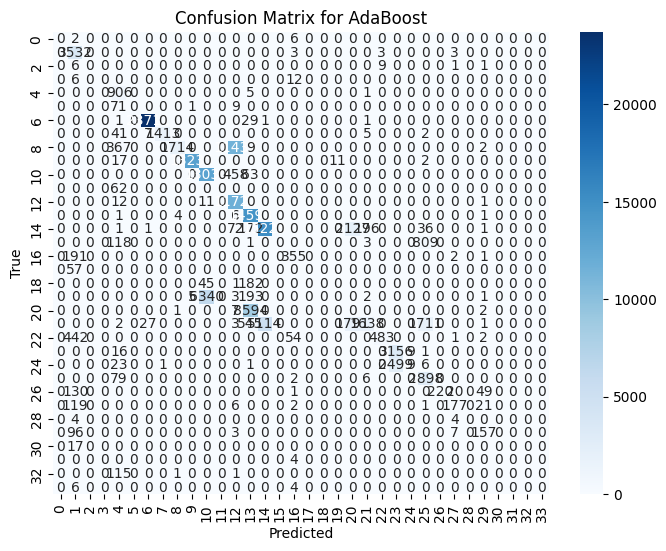

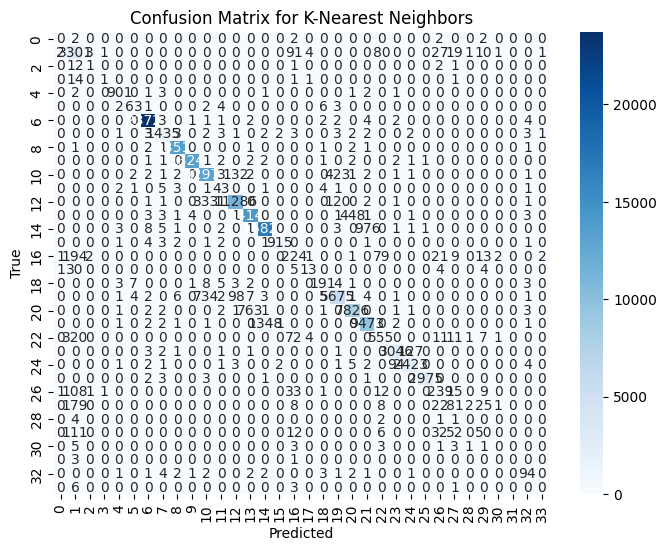

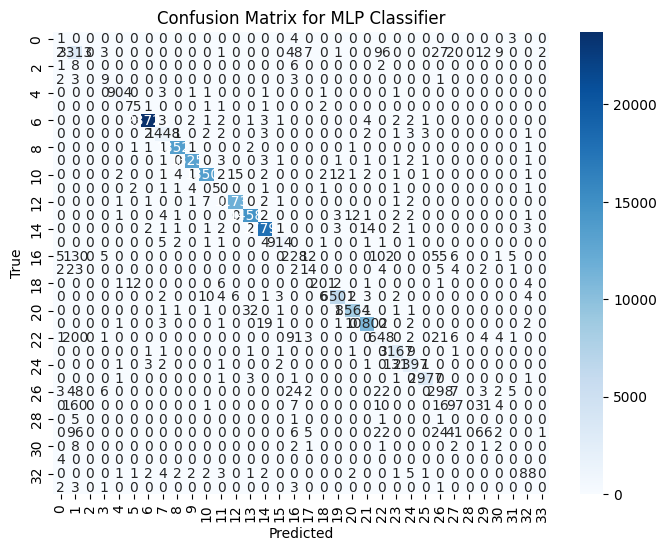

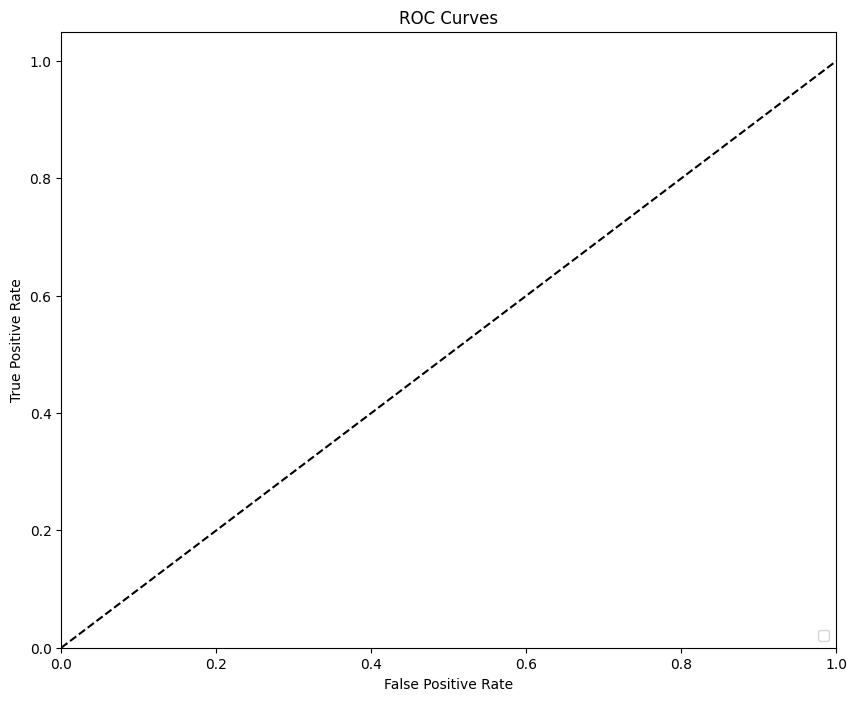


Performance metrics for all models:
                     Accuracy Precision    Recall  F1 Score ROC AUC
AdaBoost             0.707141  0.719624  0.707141  0.637846     N/A
K-Nearest Neighbors  0.949476  0.948379  0.949476  0.948356     N/A
MLP Classifier       0.986201  0.985611  0.986201  0.985517     N/A


In [11]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# Convert y_test_pos to label format for confusion matrix and classification report
# Ensure that y_test_pos is in one-hot encoded format before applying argmax
if y_test_pos.ndim > 1:  # Check if it's one-hot encoded
    y_test_labels = np.argmax(y_test_pos, axis=1)
else:
    y_test_labels = y_test_pos  # Already label encoded

# Model Initialization and Training (Machine Learning Models)
print("Initializing and training machine learning models...")
models = {
    "AdaBoost": AdaBoostClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "MLP Classifier": MLPClassifier(max_iter=300)
}

evaluation_metrics = {}

for name, model in models.items():
    print(f"Training {name}...")
    # Ensure y_train_pos is label encoded for model training
    model.fit(X_train_pos, y_train_pos.argmax(axis=1) if y_train_pos.ndim > 1 else y_train_pos)
    y_pred = model.predict(X_test_pos)

    print(f"Performance of {name}:")
    print(classification_report(y_test_labels, y_pred))
    print(confusion_matrix(y_test_labels, y_pred))

    accuracy = accuracy_score(y_test_labels, y_pred)
    precision = precision_score(y_test_labels, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test_labels, y_pred, average='weighted')
    f1 = f1_score(y_test_labels, y_pred, average='weighted')

    # Check if the model supports probability predictions (not all classifiers do)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_pos)
        roc_auc = roc_auc_score(y_test_pos, y_prob, multi_class='ovr') if y_test_pos.ndim > 1 else "N/A"
    else:
        roc_auc = "N/A"  # ROC AUC is not applicable for models that don't support predict_proba

    evaluation_metrics[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "ROC AUC": roc_auc
    }

# Step 9: Visualization of Model Performance
print("Visualizing model performance...")

# Plot Confusion Matrix
for name, model in models.items():
    y_pred = model.predict(X_test_pos)
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for name, model in models.items():
    if hasattr(model, "predict_proba"):  # Only plot ROC if model supports predict_proba
        y_prob = model.predict_proba(X_test_pos)
        if y_test_pos.ndim > 1:  # Ensure y_test_pos is one-hot encoded for roc_curve
            fpr, tpr, _ = roc_curve(y_test_pos[:, 1], y_prob[:, 1], pos_label=1)
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

# Step 10: Print Evaluation Metrics Summary
metrics_df = pd.DataFrame(evaluation_metrics).T  # Transpose for better readability
print("\nPerformance metrics for all models:")
print(metrics_df)


Training CNN model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - accuracy: 0.7918 - loss: 0.5123 - val_accuracy: 0.8838 - val_loss: 0.2998
Epoch 2/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - accuracy: 0.9278 - loss: 0.2160 - val_accuracy: 0.9660 - val_loss: 0.0926
Epoch 3/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 137s 9ms/step - accuracy: 0.9678 - loss: 0.0953 - val_accuracy: 0.9787 - val_loss: 0.0841
Epoch 4/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9730 - loss: 0.0833 - val_accuracy: 0.9774 - val_loss: 0.0805
Epoch 5/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 89s 9ms/step - accuracy: 0.9745 - loss: 0.0782 - val_accuracy: 0.9798 - val_loss: 0.0815
Epoch 6/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 82s 9ms/step - accuracy: 0.9743 - loss: 0.0776 - val_accuracy: 0.9799 - val_loss: 0.0729
Epoch 7/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - accuracy: 0.9767 - loss: 0.0758 - val_accuracy: 0.9674 - val_loss: 0.0850
Epoch 8/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 141s 9ms/step - accuracy: 0.9744 - loss

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 38s 4ms/step - accuracy: 0.7732 - loss: 0.6345 - val_accuracy: 0.8233 - val_loss: 0.3929
Epoch 2/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.8428 - loss: 0.3748 - val_accuracy: 0.8877 - val_loss: 0.3036
Epoch 3/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 44s 4ms/step - accuracy: 0.8870 - loss: 0.2887 - val_accuracy: 0.9331 - val_loss: 0.2250
Epoch 4/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.9435 - loss: 0.2067 - val_accuracy: 0.9731 - val_loss: 0.1435
Epoch 5/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9765 - loss: 0.1278 - val_accuracy: 0.9802 - val_loss: 0.1107
Epoch 6/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9798 - loss: 0.1018 - val_accuracy: 0.9810 - val_loss: 0.0956
Epoch 7/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - accuracy: 0.9806 - loss: 0.0889 - val_accuracy: 0.9815 - val_loss: 0.0867
Epoch 8/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step - accuracy: 0.9807 - loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - accuracy: 0.7217 - loss: 0.7141 - val_accuracy: 0.7982 - val_loss: 0.4511
Epoch 2/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 38s 3ms/step - accuracy: 0.7898 - loss: 0.4819 - val_accuracy: 0.8021 - val_loss: 0.4351
Epoch 3/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.7954 - loss: 0.4608 - val_accuracy: 0.8209 - val_loss: 0.4062
Epoch 4/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - accuracy: 0.8075 - loss: 0.4393 - val_accuracy: 0.8403 - val_loss: 0.3786
Epoch 5/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - accuracy: 0.8239 - loss: 0.4207 - val_accuracy: 0.8381 - val_loss: 0.3778
Epoch 6/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.8298 - loss: 0.4091 - val_accuracy: 0.8447 - val_loss: 0.3528
Epoch 7/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.8389 - loss: 0.3898 - val_accuracy: 0.8603 - val_loss: 0.3214
Epoch 8/10
9562/9562 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.8458 - loss: 0

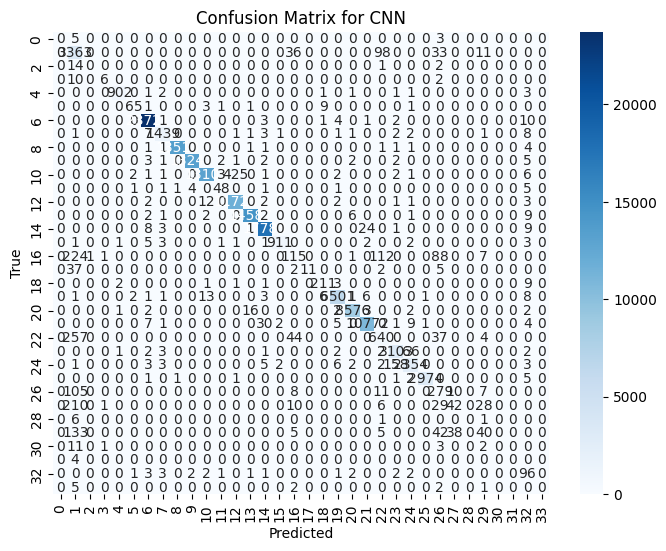

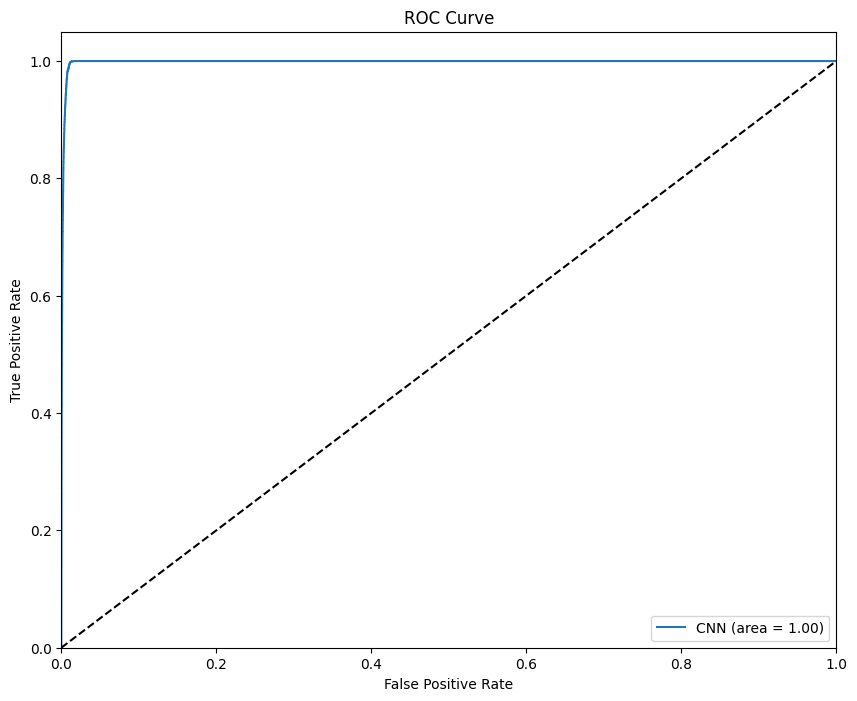


Visualizing LSTM model performance...


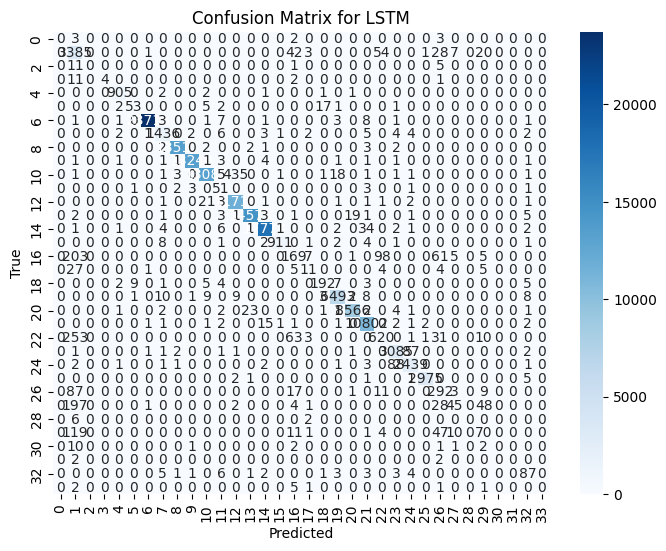

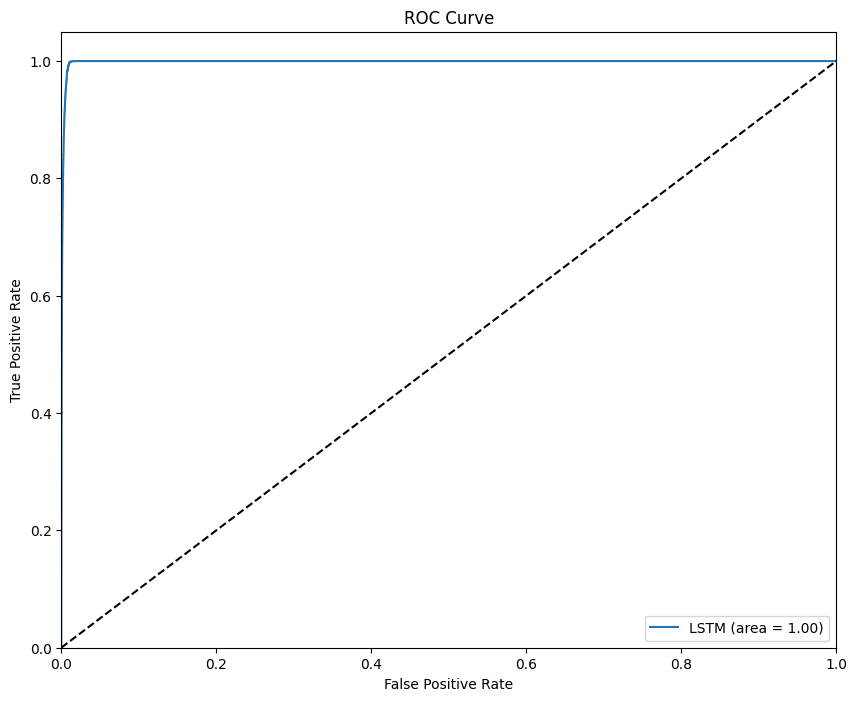


Visualizing DNN model performance...


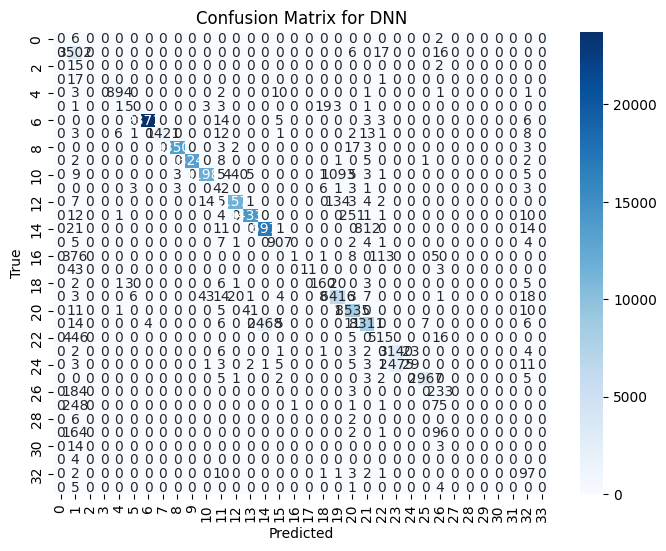

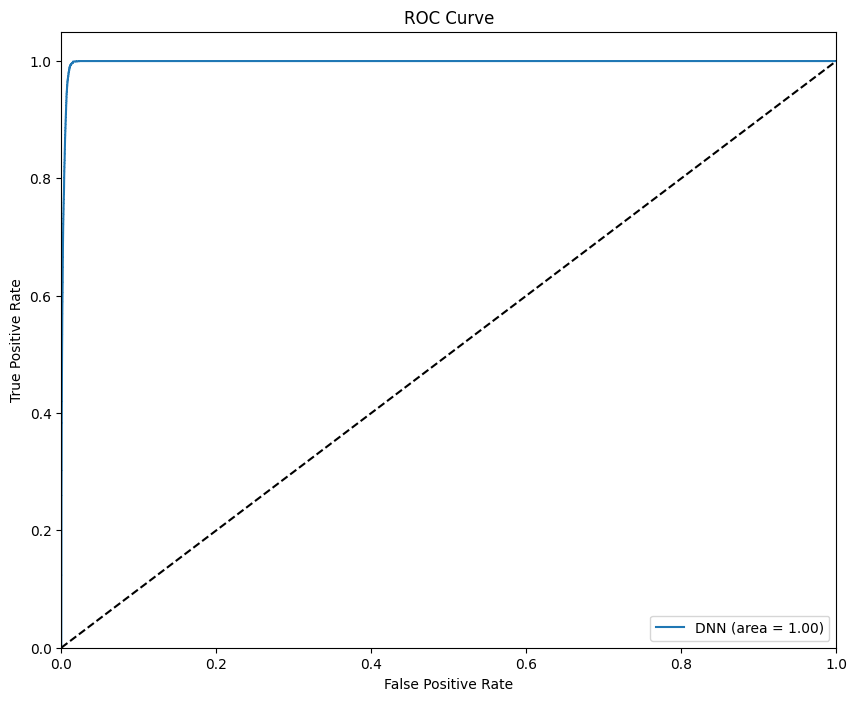


All models have been trained and evaluated.


In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, LSTM, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Number of unique classes in the positive attack labels
num_classes = len(np.unique(y_train_pos))

# One-hot encode your labels for deep learning models
y_train_pos = to_categorical(y_train_pos, num_classes=num_classes)
y_test_pos = to_categorical(y_test_pos, num_classes=num_classes)

evaluation_metrics = {}

# Training CNN Model
print("Training CNN model...")
X_train_cnn = X_train_pos.reshape(X_train_pos.shape[0], X_train_pos.shape[1], 1)
X_test_cnn = X_test_pos.reshape(X_test_pos.shape[0], X_test_pos.shape[1], 1)

cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(num_classes, activation='softmax')  # Multi-class output layer
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Multi-class loss
cnn_model.fit(X_train_cnn, y_train_pos, epochs=10, batch_size=64, validation_data=(X_test_cnn, y_test_pos))
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_cnn, y_test_pos)
y_prob_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_prob_cnn, axis=1)  # Convert probabilities to class predictions

evaluation_metrics['CNN'] = {
    "Accuracy": cnn_accuracy,
    "Precision": precision_score(y_test_pos.argmax(axis=1), y_pred_cnn, average='weighted', zero_division=1),
    "Recall": recall_score(y_test_pos.argmax(axis=1), y_pred_cnn, average='weighted'),
    "F1 Score": f1_score(y_test_pos.argmax(axis=1), y_pred_cnn, average='weighted'),
    "ROC AUC": roc_auc_score(y_test_pos, y_prob_cnn, multi_class='ovr')  # Use 'ovr' or 'ovo'
}

# Print CNN Evaluation Metrics
print("\nCNN Evaluation Metrics:")
for metric, value in evaluation_metrics['CNN'].items():
    print(f"{metric}: {value}")

# Training LSTM Model
print("\nTraining LSTM model...")
X_train_lstm = X_train_pos.reshape((X_train_pos.shape[0], 1, X_train_pos.shape[1]))
X_test_lstm = X_test_pos.reshape((X_test_pos.shape[0], 1, X_test_pos.shape[1]))

lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(1, X_train_pos.shape[1])),
    Dense(num_classes, activation='softmax')  # Multi-class output layer
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_lstm, y_train_pos, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_pos))
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_pos)
y_prob_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_prob_lstm, axis=1)  # Convert probabilities to class predictions

evaluation_metrics['LSTM'] = {
    "Accuracy": lstm_accuracy,
    "Precision": precision_score(y_test_pos.argmax(axis=1), y_pred_lstm, average='weighted', zero_division=1),
    "Recall": recall_score(y_test_pos.argmax(axis=1), y_pred_lstm, average='weighted'),
    "F1 Score": f1_score(y_test_pos.argmax(axis=1), y_pred_lstm, average='weighted'),
    "ROC AUC": roc_auc_score(y_test_pos, y_prob_lstm, multi_class='ovr')
}

# Print LSTM Evaluation Metrics
print("\nLSTM Evaluation Metrics:")
for metric, value in evaluation_metrics['LSTM'].items():
    print(f"{metric}: {value}")

# Training DNN Model
print("\nTraining DNN model...")
dnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_pos.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')  # Multi-class output layer
])

dnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
dnn_model.fit(X_train_pos, y_train_pos, epochs=10, batch_size=64, validation_data=(X_test_pos, y_test_pos))
dnn_loss, dnn_accuracy = dnn_model.evaluate(X_test_pos, y_test_pos)
y_prob_dnn = dnn_model.predict(X_test_pos)
y_pred_dnn = np.argmax(y_prob_dnn, axis=1)  # Convert probabilities to class predictions

evaluation_metrics['DNN'] = {
    "Accuracy": dnn_accuracy,
    "Precision": precision_score(y_test_pos.argmax(axis=1), y_pred_dnn, average='weighted', zero_division=1),
    "Recall": recall_score(y_test_pos.argmax(axis=1), y_pred_dnn, average='weighted'),
    "F1 Score": f1_score(y_test_pos.argmax(axis=1), y_pred_dnn, average='weighted'),
    "ROC AUC": roc_auc_score(y_test_pos, y_prob_dnn, multi_class='ovr')
}

# Print DNN Evaluation Metrics
print("\nDNN Evaluation Metrics:")
for metric, value in evaluation_metrics['DNN'].items():
    print(f"{metric}: {value}")

# Visualization of Model Performance

def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob[:, 1], pos_label=1)  # Adjust pos_label if needed
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# CNN Model Visualization
print("\nVisualizing CNN model performance...")
plot_confusion_matrix(y_test_pos.argmax(axis=1), y_pred_cnn, "CNN")
plot_roc_curve(y_test_pos.argmax(axis=1), y_prob_cnn, "CNN")

# LSTM Model Visualization
print("\nVisualizing LSTM model performance...")
plot_confusion_matrix(y_test_pos.argmax(axis=1), y_pred_lstm, "LSTM")
plot_roc_curve(y_test_pos.argmax(axis=1), y_prob_lstm, "LSTM")

# DNN Model Visualization
print("\nVisualizing DNN model performance...")
plot_confusion_matrix(y_test_pos.argmax(axis=1), y_pred_dnn, "DNN")
plot_roc_curve(y_test_pos.argmax(axis=1), y_prob_dnn, "DNN")

print("\nAll models have been trained and evaluated.")


In [13]:
import pandas as pd

# Create a DataFrame to display all the metrics for all models
metrics_df = pd.DataFrame(evaluation_metrics).T  # Transpose for better readability

# Print the DataFrame as a table
print("\nPerformance metrics for all models:")
print(metrics_df)

# Sort the DataFrame by a specific metric (e.g., F1 Score)
sorted_metrics_df = metrics_df.sort_values(by="F1 Score", ascending=False)
print("\nModels sorted by F1 Score:")
print(sorted_metrics_df)



Performance metrics for all models:
      Accuracy  Precision    Recall  F1 Score   ROC AUC
CNN   0.981409   0.980565  0.981409  0.979849  0.997188
LSTM  0.981945   0.981462  0.981945  0.980658  0.997968
DNN   0.931814   0.935432  0.931814  0.922783  0.995211

Models sorted by F1 Score:
      Accuracy  Precision    Recall  F1 Score   ROC AUC
LSTM  0.981945   0.981462  0.981945  0.980658  0.997968
CNN   0.981409   0.980565  0.981409  0.979849  0.997188
DNN   0.931814   0.935432  0.931814  0.922783  0.995211


In [14]:
# Selected 'best_model' is the MLP Classifier based on the evaluation metrics
best_model = models['MLP Classifier']

# Detecting and classifying attacks using the best model
print("Detecting and classifying attacks with the best model...")

# Apply the best model to the test set
y_pred = best_model.predict(X_test_pos)

# Map predictions back to attack types (assuming `y_pred` is label encoded)
predicted_attack_types = label_encoders['label'].inverse_transform(y_pred)

# Display some predictions
print("\nSample attack detection results:")
for i in range(10):  # Display first 10 results
    actual_label = label_encoders['label'].inverse_transform([y_test_pos[i].argmax()])[0]  # Convert one-hot to label
    print(f"Predicted: {predicted_attack_types[i]}, Actual: {actual_label}")


Detecting and classifying attacks with the best model...

Sample attack detection results:
Predicted: DDoS-TCP_Flood, Actual: DDoS-TCP_Flood
Predicted: DDoS-RSTFINFlood, Actual: DDoS-RSTFINFlood
Predicted: DDoS-ICMP_Fragmentation, Actual: DDoS-ICMP_Fragmentation
Predicted: DDoS-PSHACK_Flood, Actual: DDoS-PSHACK_Flood
Predicted: MITM-ArpSpoofing, Actual: MITM-ArpSpoofing
Predicted: DDoS-PSHACK_Flood, Actual: DDoS-PSHACK_Flood
Predicted: DDoS-RSTFINFlood, Actual: DDoS-RSTFINFlood
Predicted: DDoS-SynonymousIP_Flood, Actual: DDoS-SynonymousIP_Flood
Predicted: DDoS-UDP_Flood, Actual: DDoS-UDP_Flood
Predicted: DDoS-RSTFINFlood, Actual: DDoS-RSTFINFlood
